In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import os

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Calculate the date one year from the last date in data set.
data_prcp = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc())\
    .filter(Measurement.date >= '2016-08-23').all()


In [11]:
# Perform a query to retrieve the data and precipitation scores
df = pd.DataFrame(data_prcp, columns=['Date', 'Precipitation'])
df.dropna(axis=0, how='any', inplace=True)
df = df.set_index('Date')

# Sort the dataframe by date
df.sort_values(by='Date', ascending=True, inplace=True)
df.head(5)

,Precipitation
Date,
2016-08-23,0.70
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,1.79
2016-08-23,0.02


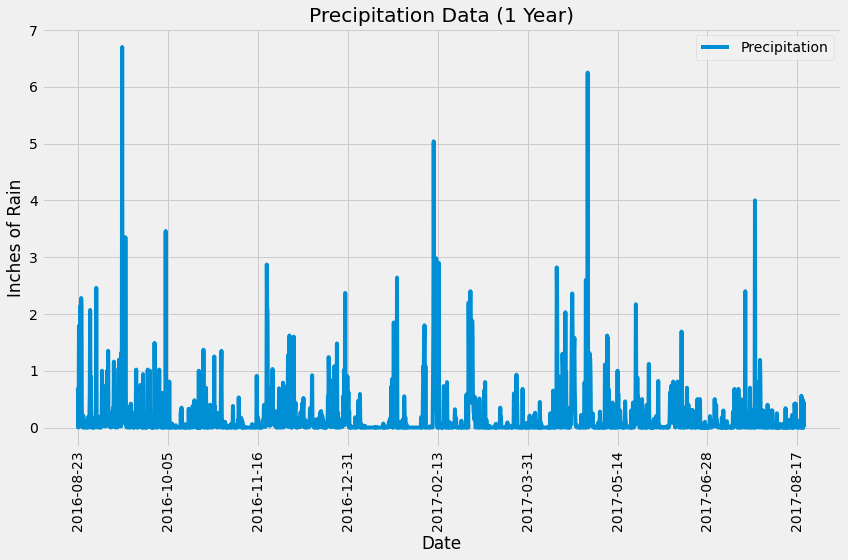

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(y='Precipitation', title='Precipitation Data (1 Year)', rot = 90, figsize=(12,8))
plt.ylabel('Inches of Rain')
plt.tight_layout()
plt.savefig("Images/Precipitation_Data")

plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.name).group_by(Station.name).count()
station_num = session.query(Measurement.station).group_by(Measurement.station).count()

print(f'There are {station_num} Stations in this dataset.')

There are 9 Stations in this dataset.


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
station_max = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).first()

print(f'Station ID {station_max[0]} is the most active station and recorded with highest number of observations.')

# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()

Station ID USC00519281 is the most active station and recorded with highest number of observations.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
#Using the most active station id, calculate the lowest, highest, and average temperatures.
#Query the last 12 months of temperature observation data for this station

sel = [Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

station_values = session.query(*sel).filter(Measurement.station == station_max[0])
station_df = pd.read_sql(station_values.statement, station_values.session.bind)
station_df.rename(columns={'station': 'Station',
                          'min_1': 'Min Temp',
                          'max_1': 'Max Temp',
                          'avg_1': 'Avg Temp'}, 
                          inplace=True)

station_df

,Station,Min Temp,Max Temp,Avg Temp
0,USC00519281,54.0,85.0,71.663781


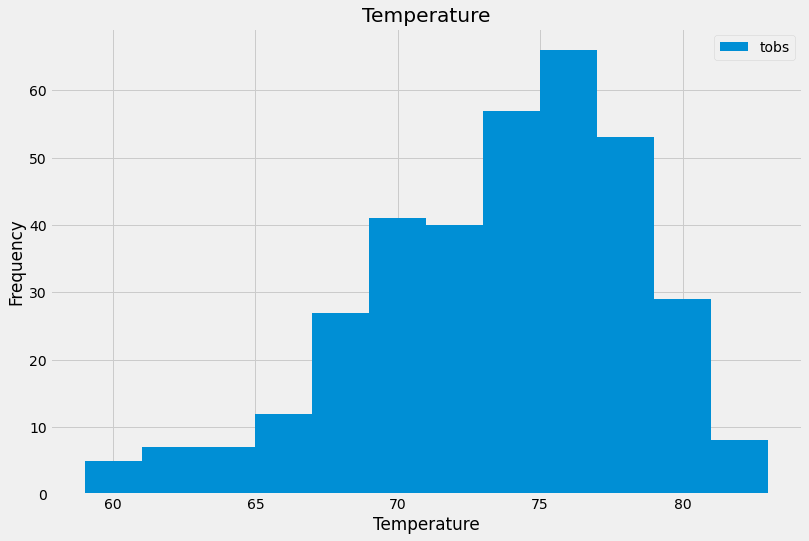

In [17]:
#Design a query to retrieve the previous 12 months of temperature observation data (TOBS)
#Plot the results as a histogram with bin = 12


# Queried last 12 months using a .filter() and created a SQL Object
station_12months = session.query(Measurement.station, Measurement.tobs)\
    .filter(Measurement.station == station_max[0])\
    .filter(Measurement.date >= '2016-08-23')

# Transformed the SQL Object into a Pandas DataFrame
station_hist_df = pd.read_sql(station_12months.statement, station_12months.session.bind)

# Plotted a histogram using plt .plot and bin=12
station_hist_df.plot.hist(bins=12, figsize=(12,8))
plt.xlabel('Temperature')
plt.ylabel("Frequency")
plt.title("Temperature")
plt.savefig('Images/Station_Histogram_Temperature')

plt.show()

# Close session

In [18]:
# Close Session
session.close()